## Expanded Analysis of the Simple Bidirectional RNN with TensorFlow TextVectorization Layer Embeddings (with Dropout = 0.2)
**(Version 1)**

**1. Import the necessary libraries and modules for this experiment**

In [2]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time
import os
import re
import string

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import nltk
from nltk.corpus import stopwords

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
# %pip install tensorflow_datasets
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as k
from sklearn.model_selection import train_test_split

In [3]:
# Set the default precision for numpy
np.set_printoptions(precision=3, suppress=True)

# Enable display of multiple outputs per Jupyter Notebook cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

---

**2. Load in the golf course reviews dataset & create a new label column**


In [4]:
file_path = "top_and_non_golf_course_reviews.csv"
df = pd.read_csv(file_path)

# Create a new label column that indicates whether the review is a top100 course or not
df['top100'] = df['label'].apply(lambda x: 1 if x == 'top100' else 0)

---

**3. Split the dataset into training, validation, and testing sets**

In [5]:
train_df, remaining = train_test_split(df, test_size=0.33, stratify=df['top100'], random_state=42)
val_df, test_df = train_test_split(remaining, test_size=0.5, stratify=remaining['top100'], random_state=42)

# Check the shape of the training, validation, and test sets
print(f"Training Dataset Shape: {train_df.shape}")
print(f"Validation Dataset Shape: {val_df.shape}")
print(f"Test Dataset Shape: {test_df.shape}")

Training Dataset Shape: (80, 11)
Validation Dataset Shape: (20, 11)
Test Dataset Shape: (20, 11)


----

**4. Convert the split DataFrames into TensorFlow Datasets**

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices(dict(train_df))
val_ds = tf.data.Dataset.from_tensor_slices(dict(val_df))
test_ds = tf.data.Dataset.from_tensor_slices(dict(test_df))

----

**5. Create `custom_stopwords` function and `text_vectorization` layer**

In [7]:
# Define a `custom_stopwords` function to remove stopwords, strip punctuation, and lowercase the text
def custom_stopwords(input_text):
    """
    Removes stopwords, strips punctuation, and lowers the input text.

    Args:
        input_text (tf.Tensor): The input text to be processed.

    Returns:
        tf.Tensor: The processed text with stopwords removed, punctuation stripped, and lowercased.
    """
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase,
                                            '[%s]' % re.escape(string.punctuation),
                                            '')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*', "")

# Download stopwords from the NLTK library
nltk.download('stopwords', quiet=True)
STOPWORDS = stopwords.words("english")

# Define the maxium sequence and token length for this experiment
max_length =  3073
max_tokens = 10000

# Create a TextVectorization layer
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
    standardize=custom_stopwords
)

True

----

**6. Adapt the TextVectorization layer to a text_only_dataset of the training dataset**

In [8]:
# Create a text_only_train_dataset which contains only the review_text column of the training dataset
text_only_train_dataset = train_ds.map(lambda x: x['review_text'])

# Adapt the TextVectorization layer to the text_only_train_dataset
text_vectorization.adapt(text_only_train_dataset)

# Create int_train_ds, int_val_ds, and int_test_ds from the train, val, and test datasets respectively using the TextVectorization layer
int_train_ds = train_ds.map(lambda x: (text_vectorization(x['review_text']), x['top100']))
int_val_ds = val_ds.map(lambda x: (text_vectorization(x['review_text']), x['top100']))
int_test_ds = test_ds.map(lambda x: (text_vectorization(x['review_text']), x['top100']))

# Batch and pad the datasets to have a sequence lenfth dimension
batch_size = 32
max_sequence_length = 3073

int_train_ds = int_train_ds.map(lambda x, y: (x, y)).padded_batch(batch_size, padded_shapes=(max_sequence_length, ()))
int_val_ds = int_val_ds.map(lambda x, y: (x, y)).padded_batch(batch_size, padded_shapes=(max_sequence_length, ()))
int_test_ds = int_test_ds.map(lambda x, y: (x, y)).padded_batch(batch_size, padded_shapes=(max_sequence_length, ()))

2024-08-11 15:05:39.148463: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


----
**7. Load in the Experiment 13 model, which was our best-performing model**

In [9]:
model = tf.keras.models.load_model("/Users/stefanjenss/Documents/Expanding-Insights-In-Golf-Course-Excellence/Saved_Models/EXP_13_RNN_TF_TV_DO.keras")

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 356) │  3,560,000 │ input[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input[0][0]       │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, None, 128) │     53,888 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, None, 128) │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 64)        │     10,304 │ dropout[0][0],    │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,248,516 (27.65 MB)

 Trainable params: 3,624,257 (13.83 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,624,259 (13.83 MB)

---
**8. Train the best-performing model**

In [10]:
# Clear any existing models in memory
tf.keras.backend.clear_session()

# Define the callbacks for the model training
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("EXP_13_Expanded_Analysis.keras", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
]

# Train the model
start_time = time.time()
history = model.fit(int_train_ds,
                    validation_data=int_val_ds,
                    epochs=20,
                    callbacks=callbacks)
end_time = time.time()
training_time = end_time - start_time

# Print the training time
print(f"Training Time: {training_time} seconds")

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9898 - loss: 0.3363 - val_accuracy: 0.6000 - val_loss: 0.6719
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9898 - loss: 0.2593 - val_accuracy: 0.6000 - val_loss: 0.6767
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9898 - loss: 0.1829 - val_accuracy: 0.6000 - val_loss: 0.6828
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 1.0000 - loss: 0.1122 - val_accuracy: 0.6000 - val_loss: 0.6883
Training Time: 20.99421215057373 seconds


---
**9. Evaluate the best-performing model on the test set**

In [11]:
# Load the best model
model = tf.keras.models.load_model("EXP_13_Expanded_Analysis.keras")

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(int_test_ds)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Get the training loss, validation loss, training accuracy, and validation accuracy from the history object
training_loss = history.history['loss'][-1] # the -1 index gets the last epoch
validation_loss = history.history['val_loss'][-1]
training_accuracy = history.history['accuracy'][-1]
validation_accuracy = history.history['val_accuracy'][-1]

"""
1.2.2 Extract the training history and add all evaluation metrics into a history DataFrame
"""
# Extract the training history into a pandas DataFrame
history_df = pd.DataFrame({
    'EXP': [13],
    'Model': ['RNN w/ TextVectorization Embeddings + Dropout (0.2)'],
    'Training Loss': [training_loss],
    'Training Accuracy': [training_accuracy],
    'Validation Loss': [validation_loss],
    'Validation Accuracy': [validation_accuracy],
    'Test Loss': [test_loss],
    'Test Accuracy': [test_accuracy],
    'Training Time': [training_time]
})

# Inspect the history DataFrame
history_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step - accuracy: 0.9000 - loss: 0.4948
Test Loss: 0.49481430649757385, Test Accuracy: 0.8999999761581421


'\n1.2.2 Extract the training history and add all evaluation metrics into a history DataFrame\n'

,EXP,Model,Training Loss,Training Accuracy,Validation Loss,Validation Accuracy,Test Loss,Test Accuracy,Training Time
0,13,RNN w/ TextVectorization Embeddings + Dropout ...,0.105204,1.0,0.688322,0.6,0.494814,0.9,20.994212


---
**11. Create a Confusion Matrix for the Best-Performing Model**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


2024-08-11 15:07:29.907406: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


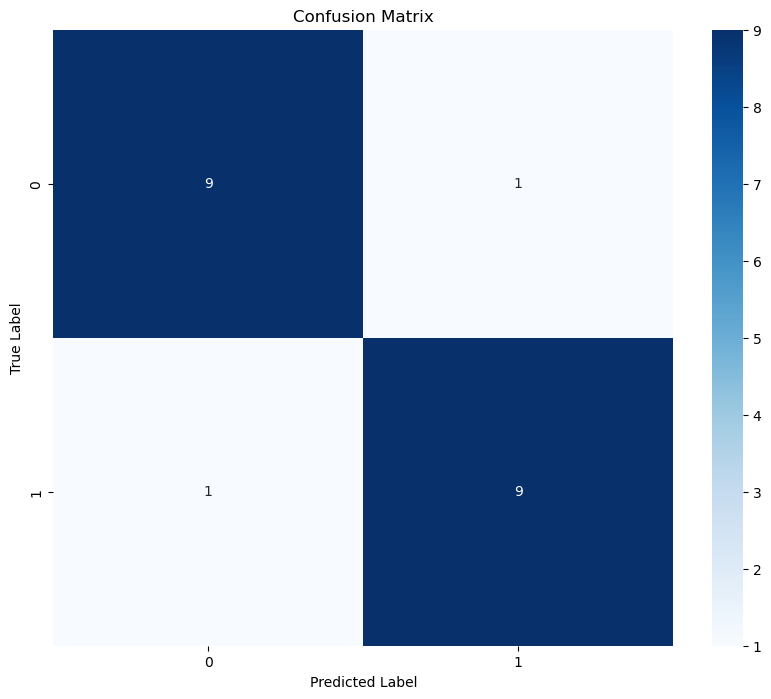

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.90      0.90      0.90        10

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



In [14]:
# 2. Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print(classification_report(y_true, y_pred))

# Get predictions on the test set
y_pred = model.predict(int_test_ds)
y_pred_classes = (y_pred > 0.5).astype(int).reshape(-1)
y_true = np.concatenate([y for x, y in int_test_ds], axis=0)

# Call the function
plot_confusion_matrix(y_true, y_pred_classes)

----
**12. Create a t-SNE plot for the Best-Performing Model**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step


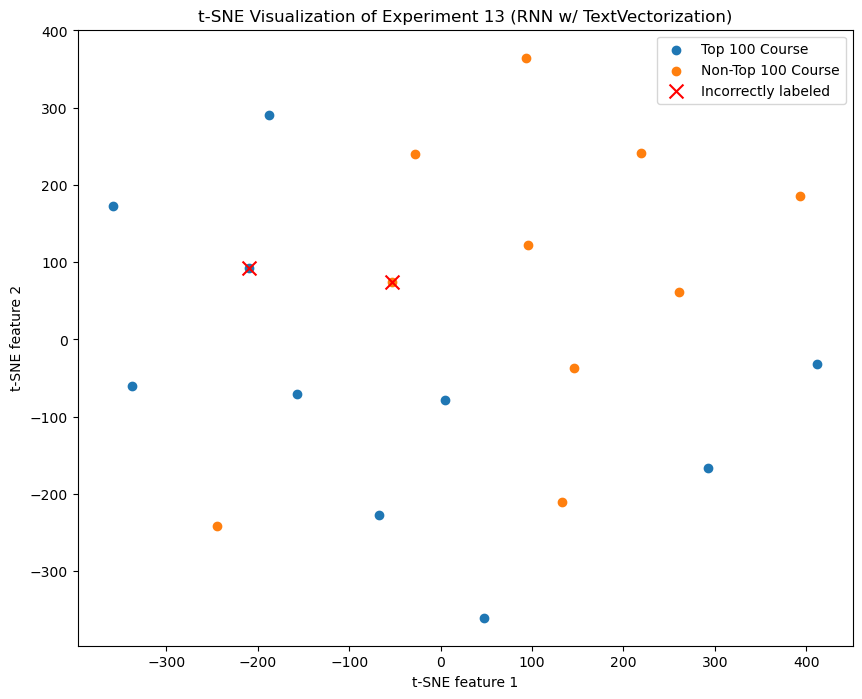

In [40]:
def plot_tsne(embeddings, y_true, y_pred_classes):
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, embeddings.shape[0]-1))
    tsne_results = tsne.fit_transform(embeddings)
    
    # Identify incorrectly labeled points
    incorrect_idx = np.where(y_true != y_pred_classes)[0]
    
    plt.figure(figsize=(10, 8))
    labels = ['Top 100 Course', 'Non-Top 100 Course']
    for label in np.unique(y_true):
        idx = np.where(y_true == label)[0]
        plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], label=labels[label])
    
    plt.scatter(tsne_results[incorrect_idx, 0], tsne_results[incorrect_idx, 1], c='red', marker='x', s=100, label='Incorrectly labeled')
    plt.legend()
    plt.title('t-SNE Visualization of Experiment 13 (RNN w/ TextVectorization)')
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.show()

# Get embeddings from the layer before the final dense layer
embedding_model = keras.Model(inputs=model.input, outputs=model.layers[-2].output)
embeddings = embedding_model.predict(int_test_ds)

# Flatten the embeddings if necessary
if len(embeddings.shape) > 2:
    embeddings = embeddings.reshape(embeddings.shape[0], -1)

# Call the function
plot_tsne(embeddings, y_true, y_pred_classes)

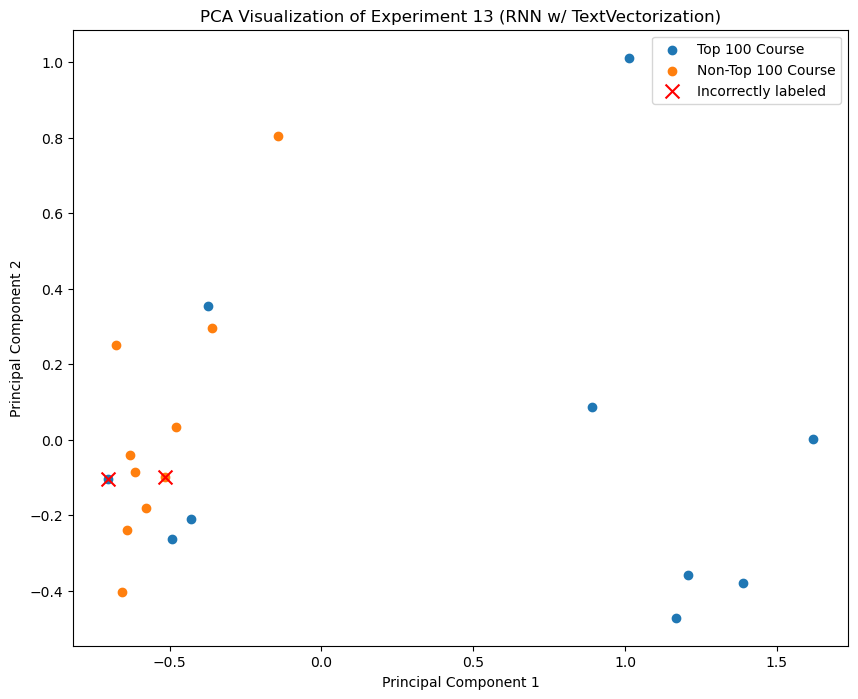

In [41]:
from sklearn.decomposition import PCA

def plot_pca(embeddings, y_true, y_pred_classes):
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(embeddings)
    
    # Identify incorrectly labeled points
    incorrect_idx = np.where(y_true != y_pred_classes)[0]
    
    plt.figure(figsize=(10, 8))
    labels = ['Top 100 Course', 'Non-Top 100 Course']
    for label in np.unique(y_true):
        idx = np.where(y_true == label)[0]
        plt.scatter(pca_results[idx, 0], pca_results[idx, 1], label=labels[label])
    
    plt.scatter(pca_results[incorrect_idx, 0], pca_results[incorrect_idx, 1], c='red', marker='x', s=100, label='Incorrectly labeled')
    plt.legend()
    plt.title('PCA Visualization of Experiment 13 (RNN w/ TextVectorization)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()
    
# Call the function
plot_pca(embeddings, y_true, y_pred_classes)